# Installing bnlp toolkit and bnltk library

In [43]:
pip install bnlp_toolkit

In [11]:
pip install bnltk

In [12]:
pip install -U bnlp_toolkit

# Importing Library

In [44]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bnlp.corpus import stopwords
from bnlp.corpus.util import remove_stopwords

from bnltk.stemmer import BanglaStemmer
from pandas import read_excel
import re
from re import sub
import multiprocessing

import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

# Read dataset

In [45]:
from google.colab import drive
#drive.mount('/content/drive')
dataset=pd.read_csv('/content/Covid vaccine data.csv')


In [31]:
dataset.shape

(418, 2)

Non-urgent: 21900.00%, Urgent: 19900.00%


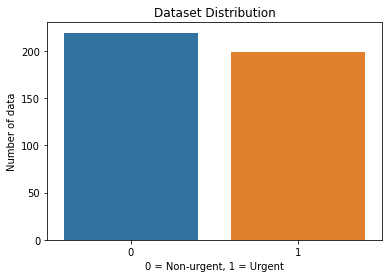

In [16]:
target_vc = dataset["Polarity"].value_counts(normalize=False)
print("Non-urgent: {:.2%}, Urgent: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Dataset Distribution")
plt.xlabel("0 = Non-urgent, 1 = Urgent")
plt.ylabel("Number of data")
plt.show()

# Data Preprocessing

In [56]:
import re
corpus=[]
max=0
for i in range(0,418):
    review = re.sub('[\!"#$%&()*,./:;<=>?@[\\]^`{|}~\t\n।+-]', ' ', dataset['Text'][i])
    review=review.replace('_',' ')
    review=review.replace('ঃ',' ')
    review = re.sub('[a-zA-Z0-9]+', ' ', review)    
    review = re.sub('[''````£|¢|Ñ/=EROero।!“’<>‘॥”‰\'🤓⌚🤰🥺⚽️✌�￰🥀🤣🤡🤗🤐🤦🤔⏩⏹￰]', ' ', review)               
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations 
                           u"\\U0001f90f" 
                           u"\\U0001f9cf"
                           u"\U0001fa78"  
                           "]+", flags=re.UNICODE)
    review=emoji_pattern.sub(r'', review)
    #review=str(review)
    #review=review.split()
    '''review=review.replace('A', 'এ')
    review=review.replace('B', 'বি')
    review=review.replace('AB', 'এবি')
    review=review.replace('O', 'ও')
    review=review.replace('+','পজিটিভ')
    review=review.replace('-','নেগেটিভ')'''
    review=review.lower()
    bn_stemmer = BanglaStemmer()
    review=bn_stemmer.stem(review)
    review = remove_stopwords(review, stopwords)
    #review=str(review)
    #review=review.split()
    review=' '.join(review)
    corpus.append(review)
    if(max<len(review)):
      max=len(review)
print(max)


384


In [55]:
#corpus

# Feature Selection

In [75]:
# TF-IDF process
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X= cv.fit_transform(corpus).toarray()
y= dataset.iloc[:, 1].values
#print(X)
#print(y)

#SVM with 80:20 spliting

In [35]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=0)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
# Fitting SVC to the training set
from sklearn.svm import SVC
classifier=SVC(kernel='linear',random_state=0)
classifier.fit(X_train, y_train)



SVC(kernel='linear', random_state=0)

In [22]:
#predicting the Test set results
y_pred=classifier.predict(X_test)




Confusion Matrix for PassiveAggressiveClassifier


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f852fd9fad0>)

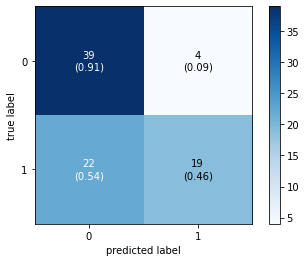

In [23]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [40]:
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy)

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)

from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)


Accuracy 0.690
precision 0.826
Recall 0.463
f1_score 0.594


# SVM with 10-fold cross validation

In [42]:
#Applying 10-fold cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True,random_state=0)
# evaluate model
from sklearn.svm import SVC
classifier=SVC(kernel='linear',random_state=0)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('Accuracy %.3f'%mean(scores))
print('precision %.3f'%np.mean(precision))
print('Recall %.3f'%np.mean(recall))
print('f1_score %.3f'%np.mean(f1))

Accuracy 0.727
precision 0.767
Recall 0.613
f1_score 0.672


# Decision Tree with 80:20 spliting

In [48]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [49]:
# Fitting Decision Tree to the training set
training_accuracy = []
test_accuracy = []
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(criterion="entropy", random_state=0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Confusion Matrix for PassiveAggressiveClassifier


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f852e1e6990>)

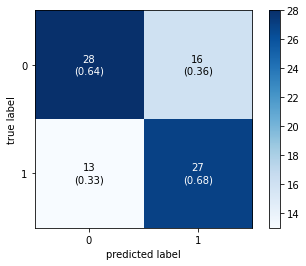

In [50]:
#predicting the Test set results
y_pred=classifier.predict(X_test)


#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [51]:
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy) 

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)


from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)


Accuracy 0.655
precision 0.628
Recall 0.675
f1_score 0.651


# Decision Tree with 10-fold cross validation

In [60]:
#Applying 10-fold cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True, random_state=0)
# evaluate model
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(criterion="entropy", random_state=0)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.699
0.722
0.568
0.631


# Naive Bayes with 80:20 spliting

In [61]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion Matrix for PassiveAggressiveClassifier
Accuracy 0.631
precision 0.565
Recall 0.975
f1_score 0.716


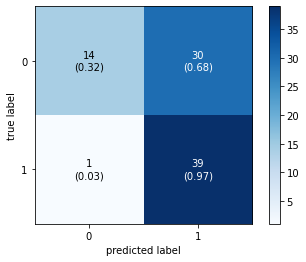

In [65]:
# Fitting SVC to the training set
from sklearn.naive_bayes import GaussianNB
classifier=GaussianNB()
classifier.fit(X_train, y_train)
#predicting the Test set results
y_pred=classifier.predict(X_test)
#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy)

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)

from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)

# Naive Bayes with 10-fold cross validation

In [69]:
#Applying 10-fold cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True, random_state=0)
# evaluate model
from sklearn.naive_bayes import GaussianNB
classifier=GaussianNB()
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.624
0.575
0.815
0.669


# Random Forest with 80:20 spliting

In [70]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=0)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion Matrix for PassiveAggressiveClassifier
Accuracy 0.702
precision 0.864
Recall 0.463
f1_score 0.603


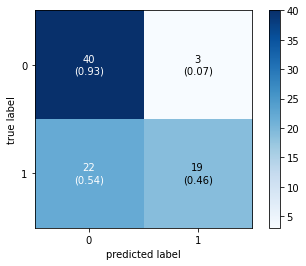

In [71]:
# Fitting Random Forest to the training set
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
classifier.fit(X_train, y_train)

#predicting the Test set results
y_pred=classifier.predict(X_test)
#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy)

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)

from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)

# Random Forest with 10-fold cross validation

In [76]:
#Applying 10-fold cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True, random_state=0)
# evaluate model
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.708
0.738
0.597
0.651
